## Dataset

In [5]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [6]:
# Data_path = "/data/behavioral-cloning/train_data_new/"
Data_path = "train_data/"
Img_path = Data_path + "IMG/"
df = pd.read_csv(Data_path + "driving_log.csv", names=['center', 'left', 'right', 'steering', 'gas', 'brake', 'speed'])

replace_str = '/home/jaeoh2/Tools/linux_sim/train_data_new/'
df['left'] = df['left'].str.replace(replace_str, Data_path)
df['right'] = df['right'].str.replace(replace_str, Data_path)
df['center'] = df['center'].str.replace(replace_str, Data_path)

In [7]:
df[['center', 'steering']].to_csv(Data_path + 'dataset.txt', header=None, index=None, sep=' ', mode='w')

In [8]:
#data balancing refer from https://navoshta.com/end-to-end-deep-learning/
balanced = pd.DataFrame()
bins = 200
bin_n = 200

start = 0
for end in np.linspace(0, 1, num=bins):
    df_range = df[(np.absolute(df.steering) >= start) & (np.absolute(df.steering) < end)]
    range_n = min(bin_n, df_range.shape[0])
    if range_n > 0:
        balanced = pd.concat([balanced, df_range.sample(range_n)])
    start = end
balanced.to_csv(Data_path + 'driving_log_balanced.csv', index=False)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1e44141518>]],
      dtype=object)

/home/jaeoh2/miniconda3/envs/dlenv/lib/python3.6/site-packages/matplotlib/font_manager.py:278: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


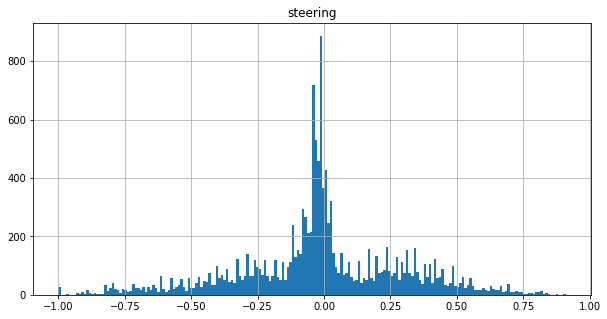

In [9]:
df.hist(column=['steering'], bins=bins, figsize=(10,5))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1e43d86898>]],
      dtype=object)

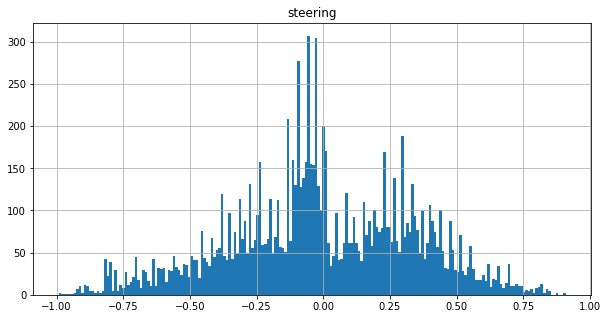

In [10]:
balanced.hist(column=['steering'], bins=bins, figsize=(10,5))

In [11]:
num_examples = len(df)
num_balanced = len(balanced)
print("Number of examples : {}\nNumber of balanced : {}".format(num_examples, num_balanced))

Number of examples : 13977
Number of balanced : 10775


## Data Augmentation

In [12]:
import random
import os, sys
import csv
import cv2
from tqdm import tqdm

(<matplotlib.axes._subplots.AxesSubplot at 0x7f1e429cef98>,
 Text(0.5,1,'0.36'),
 (-0.5, 319.5, 159.5, -0.5))

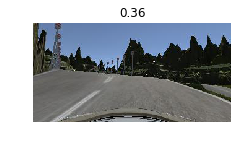

In [13]:
#test
ran_idx = random.randint(0, num_examples)
test_img = mpimg.imread(df.center[ran_idx])
test_str = float(df.steering[ran_idx])
plt.subplot(2,1,1), plt.imshow(test_img), plt.title(round(test_str,2)), plt.axis('off')


In [14]:
center = balanced.center.tolist()
left = balanced.left.tolist()
right = balanced.right.tolist()
steering = balanced.steering.tolist()
leftsteering = (balanced.steering + 0.25).tolist()
rightsteering = (balanced.steering - 0.25).tolist()

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
X_train = center + left + right
y_train = steering + leftsteering + rightsteering

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

In [16]:
import math
import cv2
height=64
width=64
def preprocess_image(X):
    X = cv2.resize(X[60:140,:], (width,height), interpolation=cv2.INTER_AREA)
    #X = cv2.cvtColor(X, cv2.COLOR_RGB2YUV)
    
    return X

In [17]:
def transform_images(X, y):
    X = preprocess_image(X)
    return X,y

In [18]:
# Print iterations progress
def print_progress(iteration, total):
    """
    Call in a loop to create terminal progress bar
    
    Parameters
    ----------
        
    iteration : 
                Current iteration (Int)
    total     : 
                Total iterations (Int)
    """
    str_format = "{0:.0f}"
    percents = str_format.format(100 * (iteration / float(total)))
    filled_length = int(round(100 * iteration / float(total)))
    bar = '█' * filled_length + '-' * (100 - filled_length)

    sys.stdout.write('\r |%s| %s%%' % (bar, percents)),

    if iteration == total:
        sys.stdout.write('\n')
    sys.stdout.flush()

In [19]:
def get_transform_images(Xs, ys, n_each=10):
        
    X_arr = []
    y_arr = []
    
    
    #Parallel(n_jobs=nprocs)(delayed(preprocess_image)(imfile) for imfile in Xs)
    
    for i, (x, y) in enumerate(zip(Xs,ys)):
        for _ in range(n_each):
            img = mpimg.imread(x)
            img_trf, label_trf = transform_images(img, y)
            X_arr.append(img_trf)
            y_arr.append(label_trf)
        print_progress(i+1, len(Xs))
    X_arr = np.asarray(X_arr, dtype=np.float32)
    y_arr = np.asarray(y_arr, dtype=np.float32)
    
    return X_arr, y_arr

In [20]:
X_trf, y_trf = get_transform_images(X_train, y_train, n_each=3)

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100%


In [21]:
X_trf_val, y_trf_val = get_transform_images(X_valid, y_valid, n_each=1)

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100%


In [22]:
print("Saving preprocessed Train images")
np.save(Data_path + "TrainX.npy", X_trf)
np.save(Data_path + "Trainy.npy", y_trf)
np.save(Data_path + "ValidX.npy", X_trf_val)
np.save(Data_path + "Validy.npy", y_trf_val)
print("Saving Done")

Saving preprocessed Train images
Saving Done


In [23]:
X_train, y_train, X_valid, y_valid = X_trf, y_trf, X_trf_val, y_trf_val

## Model

In [1]:
import numpy as np
Data_path = "train_data/"

X_train = np.load(Data_path + "TrainX.npy")
y_train = np.load(Data_path + "Trainy.npy")
X_valid = np.load(Data_path + "ValidX.npy")
y_valid = np.load(Data_path + "Validy.npy")

In [2]:
from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, MaxPool2D
from keras.layers import Dense, Dropout, Flatten, Cropping2D
from keras.optimizers import adam

/home/jaeoh2/miniconda3/envs/dlenv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as K
from keras.layers import Lambda

In [4]:
#Model Configurations
img_height = 64
img_width = 64
img_ch = 3

f_size = 3
learning_rate = 1e-2
activation = 'elu'

In [5]:
def build_model():
    model = Sequential()
    #model.add(Lambda(lambda x: x/255. -0.5, input_shape=(img_height, img_width, img_ch)))
    model.add(Conv2D(16,(3,3), activation=activation, padding='valid' , input_shape=(img_height, img_width, img_ch)))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Conv2D(32,(3,3), activation=activation, padding='valid'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Conv2D(64,(3,3), activation=activation, padding='valid'))
    model.add(MaxPool2D(pool_size=(2,2)))
    
    model.add(Flatten())
    model.add(Dense(500, activation=activation))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation=activation))
    model.add(Dropout(0.25))
    model.add(Dense(20, activation=activation))
    model.add(Dropout(0.25))
    model.add(Dense(1))
    
    model.summary()
    model.compile(loss='MSE', optimizer='adam', metrics=['accuracy'])
    
    return model

In [6]:
model = build_model()
model_checkpoint = ModelCheckpoint('model.h5', monitor='loss', save_best_only=True)
model_earlystopping = EarlyStopping(monitor='loss')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 16)        448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2304)              0         
__________

In [9]:
model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, shuffle=True,
          validation_data=(X_valid, y_valid),
          callbacks=[model_checkpoint, model_earlystopping])

Train on 77580 samples, validate on 6465 samples
Epoch 1/10
77580/77580 [==============================] - 11s 138us/step - loss: 0.0390 - acc: 0.0062 - val_loss: 0.0305 - val_acc: 0.0062
Epoch 2/10
77580/77580 [==============================] - 11s 137us/step - loss: 0.0354 - acc: 0.0062 - val_loss: 0.0288 - val_acc: 0.0062
Epoch 3/10
77580/77580 [==============================] - 11s 137us/step - loss: 0.0337 - acc: 0.0062 - val_loss: 0.0276 - val_acc: 0.0062
Epoch 4/10
77580/77580 [==============================] - 11s 139us/step - loss: 0.0313 - acc: 0.0062 - val_loss: 0.0266 - val_acc: 0.0062
Epoch 5/10
77580/77580 [==============================] - 11s 136us/step - loss: 0.0301 - acc: 0.0062 - val_loss: 0.0263 - val_acc: 0.0062
Epoch 6/10
77580/77580 [==============================] - 11s 138us/step - loss: 0.0284 - acc: 0.0062 - val_loss: 0.0242 - val_acc: 0.0062
Epoch 7/10
77580/77580 [==============================] - 11s 138us/step - loss: 0.0276 - acc: 0.0062 - val_loss: 0.0